## Goal

This article has as it's goal creating an artificial intelligence capable of identifying four types of bear: grizzly, polar, black and pandas.

with that in mind, the necessary libraries were installed:

In [2]:
    !pip install spacy --upgrade
    !pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 40.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.0
    Uninstalling spacy-3.6.0:
      Successfully uninstalled spacy-3.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.2.1 which is incompatible.


So it is possible to look for images of such bears in the internet, the function search_images was created in the following cell.

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Now, this function is used and the URLs returned by it are used by another function, download_url, to download the image files. Our goal in this notebook is making an AI capable of identifying the following bears:

In [11]:
from fastdownload import download_url
from fastai.vision.all import *
bears = ['panda_bear.jpg','grizly_bear.jpg','black_bear.jpg','polar_bear.jpg']
for o in bears:
    photo = search_images(o,max_images=1)
    download_url(photo[0], o, show_progress=True)

Searching for 'panda_bear.jpg'


Searching for 'grizly_bear.jpg'


Searching for 'black_bear.jpg'


Searching for 'polar_bear.jpg'


the files were all stored in the root folder:

In [12]:
!ls

black_bear.jpg	grizly_bear.jpg  panda_bear.jpg  polar_bear.jpg


Fast.ai can work with images in the root folder via the .open method, see below.
 the to_thumb method was used so we can actually see the pictures that we have as a goal classifying:

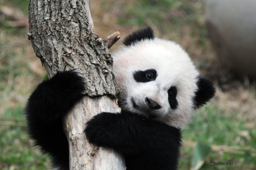

In [13]:
im1 = Image.open(bears[0])
im1.to_thumb(256,256)

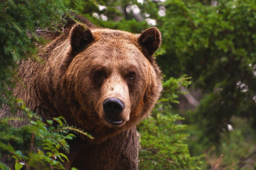

In [8]:
im2 = Image.open(bears[1])
im2.to_thumb(256,256)

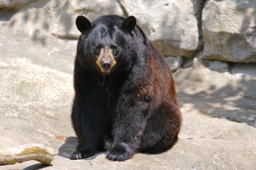

In [9]:
im3 = Image.open(bears[2])
im3.to_thumb(256,256)

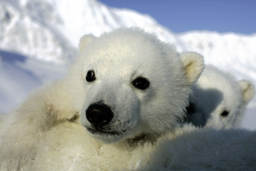

In [10]:
im4 = Image.open(bears[3])
im4.to_thumb(256,256)

## Getting the dataset

In order to classify the previously downloaded images an dataset is required to train the AI model, so the  function  search_images was used again in conjuction with the download_images function. The scientific name of the animals was used to avoid errors:

In [14]:
searches = 'Ailuropoda_melanoleuca','Ursus_arctos_horribilis','Ursus_americanus','Ursus_maritimus'
path = Path('bear_idetifier')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(1)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(1)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(1)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Ailuropoda_melanoleuca photo'
Searching for 'Ailuropoda_melanoleuca sun photo'
Searching for 'Ailuropoda_melanoleuca shade photo'
Searching for 'Ursus_arctos_horribilis photo'
Searching for 'Ursus_arctos_horribilis sun photo'
Searching for 'Ursus_arctos_horribilis shade photo'
Searching for 'Ursus_americanus photo'
Searching for 'Ursus_americanus sun photo'
Searching for 'Ursus_americanus shade photo'
Searching for 'Ursus_maritimus photo'
Searching for 'Ursus_maritimus sun photo'
Searching for 'Ursus_maritimus shade photo'


In [15]:


failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)



3

the cell above removes pictures that were incorrectly downloaded.

In [16]:
!ls

bear_idetifier	black_bear.jpg	grizly_bear.jpg  panda_bear.jpg  polar_bear.jpg


the cell below organize the images downloaded in  a Data block that will later be used to train the AI, here is what which parameter means:

ImageBlock: The dataset is made of Images.
category block: The images will be classified in categories

get_items=get_image_files : gets the image files so they are used as data.

splitter=RandomSplitter(valid_pct=0.2, seed=42): separates 20% of the data for the

validation set, the rest is training set.

get_y=parent_label: the labels are the name of the parent folder where the pictures are.

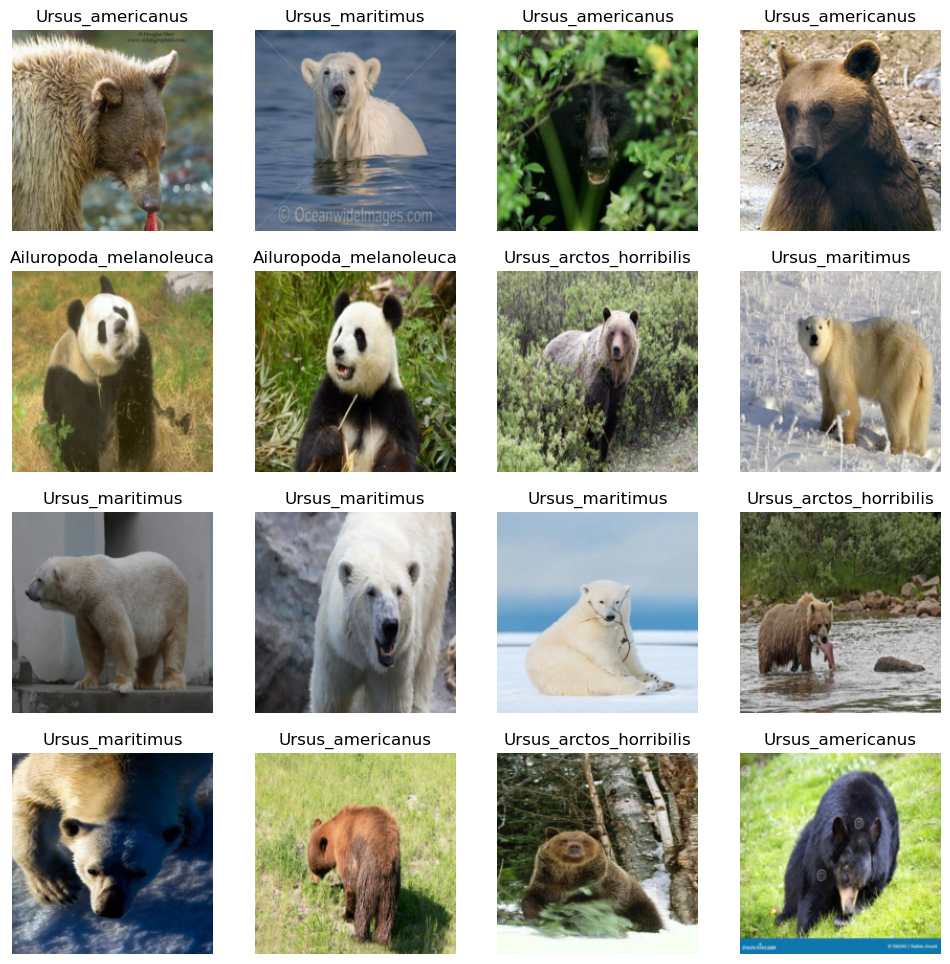

In [18]:


dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=16)



the cell below downloads the resnet18 pre-trained model and fine tunes it to our data-set

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.8MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.775512,0.417859,0.166667,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.299364,0.213087,0.045455,00:28
1,0.162533,0.207942,0.075758,00:28
2,0.111109,0.171442,0.045455,00:28


now we can classify the images previously downloaded according to the model and get the probability the classification is correct:

This is a: Ailuropoda_melanoleuca.
Probability it's a panda: 1.0000


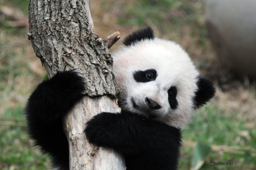

In [25]:
which_bear,_,probs = learn.predict(PILImage.create(bears[0]))
print(f"This is a: {which_bear}.")
print(f"Probability it's a panda: {probs[0]:.4f}")
im1.to_thumb(256,256)

This is a: Ursus_arctos_horribilis.
Probability it's a grizzly bear: 0.7406


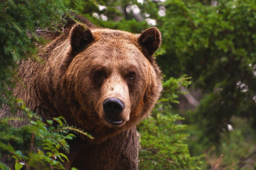

In [22]:
which_bear,_,probs = learn.predict(PILImage.create(bears[1]))
print(f"This is a: {which_bear}.")
print(f"Probability it's a grizzly bear: {probs[2]:.4f}")
im2.to_thumb(256,256)

This is a: Ursus_americanus.
Probability it's a black bear: 0.9906


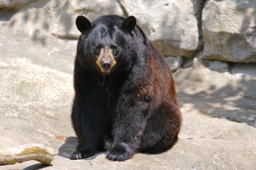

In [23]:
which_bear,_,probs = learn.predict(PILImage.create(bears[2]))
print(f"This is a: {which_bear}.")
print(f"Probability it's a black bear: {probs[1]:.4f}")
im3.to_thumb(256,256)

This is a: Ursus_maritimus.
Probability it's a polar bear: 0.9995


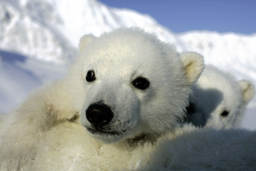

In [26]:
which_bear,_,probs = learn.predict(PILImage.create(bears[3]))
print(f"This is a: {which_bear}.")
print(f"Probability it's a polar bear: {probs[3]:.4f}")
im4.to_thumb(256,256)